<a href="https://colab.research.google.com/github/TrzeciakPiotr2300/Uczenie_Maszynowe_2025/blob/main/HW11-autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

SEED = 0

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)


# Reading MNIST Dataset
----------------------------------

In [2]:
import torch
import torchvision
from matplotlib import pyplot

transform = torchvision.transforms.ToTensor() #Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]

     # note - we are NOT normalizing pixels, as we want to keep 0-1 range

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)   #we do shuffle it to give more randomizations to training epochs

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=2048,
                                         shuffle=False)

testset_1 = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader_1 = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.60MB/s]


# Encoder and Decoder Networks
-----------------

Autoencoder is an Encoder followed by a Decoder, as in this diagram: ![Autoencoder](https://github.com/SzymonNowakowski/Machine-Learning-2024/raw/master/autoencoder_diagram.png
)



## Encoder

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderMLP(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()                        # 1x28x28 -> 784
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, bottleneck_dimensionality)  # -> bottleneck

    def forward(self, x):              # B, 1, 28, 28             moreover, input data is in [0, 1]
        x = self.flatten(x)            # B, 784
        x = self.relu(self.linear1(x)) # B, 256
        x = self.relu(self.linear2(x)) # B, 64
        x = self.linear3(x)            # B, bottleneck
        return x


## Decoder

In [4]:

class DecoderMLP(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(bottleneck_dimensionality, 64)
        self.linear2 = nn.Linear(64, 256)
        self.linear3 = nn.Linear(256, 784)
        self.sigmoid = nn.Sigmoid()             # Output in [0, 1] to mimick the true input data

    def forward(self, x):                  # B, bottleneck
        x = self.relu(self.linear1(x))     # B, 64
        x = self.relu(self.linear2(x))     # B, 256
        x = self.sigmoid(self.linear3(x))  # B, 784
        return x.view(-1, 1, 28, 28)       # B, 1, 28, 28    - reshape to image size. -1 means "infer the proper dimensionality automatically"


## Autoencoder


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, bottleneck_dimensionality):
        super().__init__()
        self.encoder = EncoderMLP(bottleneck_dimensionality)
        self.decoder = DecoderMLP(bottleneck_dimensionality)

    def forward(self, x):      # B, 1, 28, 28
        x = self.encoder(x)    # B, bottleneck
        x = self.decoder(x)    # B, 1, 28, 28
        return x

# Training Loop
----------------------

Beware: Training takes around 10 minutes on a GPU, and closer to an hour on a CPU. I had the joy of discovering that firsthand when Colab temporarily revoked my GPU access.

In [ ]:
import time
import torch
import torch.nn.functional as F

# Start timing
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = Autoencoder(bottleneck_dimensionality=2).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

EPOCHS = 200
train_loss_history = []
test_loss_history = []

for epoch in range(EPOCHS):
    # === Train ===
    net.train()
    epoch_loss_sum = 0.0
    epoch_sample_count = 0

    for batch_inputs, _ in trainloader:
        batch_inputs = batch_inputs.to(device)

        optimizer.zero_grad()
        reconstructed = net(batch_inputs)

        loss = F.mse_loss(reconstructed, batch_inputs, reduction='mean')
        loss.backward()
        optimizer.step()

        batch_size = batch_inputs.size(0)
        epoch_loss_sum += loss.item() * batch_size
        epoch_sample_count += batch_size

    avg_train_loss = epoch_loss_sum / epoch_sample_count
    train_loss_history.append(avg_train_loss)

    # === Evaluate on test set ===
    net.eval()
    test_loss_sum = 0.0
    test_sample_count = 0
    with torch.no_grad():
        for batch_inputs, _ in testloader:
            batch_inputs = batch_inputs.to(device)
            reconstructed = net(batch_inputs)
            loss = F.mse_loss(reconstructed, batch_inputs, reduction='mean')

            batch_size = batch_inputs.size(0)
            test_loss_sum += loss.item() * batch_size
            test_sample_count += batch_size

    avg_test_loss = test_loss_sum / test_sample_count
    test_loss_history.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss (averaged over the epoch): {avg_train_loss:.6f} | Test Loss (after the epoch): {avg_test_loss:.6f}")

# End timing
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")


Working on cuda
Epoch 000 | Train Loss (averaged over the epoch): 0.126929 | Test Loss (after the epoch): 0.073962
Epoch 010 | Train Loss (averaged over the epoch): 0.051952 | Test Loss (after the epoch): 0.051486
Epoch 020 | Train Loss (averaged over the epoch): 0.047112 | Test Loss (after the epoch): 0.046838
Epoch 030 | Train Loss (averaged over the epoch): 0.044065 | Test Loss (after the epoch): 0.043873
Epoch 040 | Train Loss (averaged over the epoch): 0.042236 | Test Loss (after the epoch): 0.042358
Epoch 050 | Train Loss (averaged over the epoch): 0.041195 | Test Loss (after the epoch): 0.041501
Epoch 060 | Train Loss (averaged over the epoch): 0.040448 | Test Loss (after the epoch): 0.040919
Epoch 070 | Train Loss (averaged over the epoch): 0.039921 | Test Loss (after the epoch): 0.040518
Epoch 080 | Train Loss (averaged over the epoch): 0.039447 | Test Loss (after the epoch): 0.040119
Epoch 090 | Train Loss (averaged over the epoch): 0.039068 | Test Loss (after the epoch): 0.0

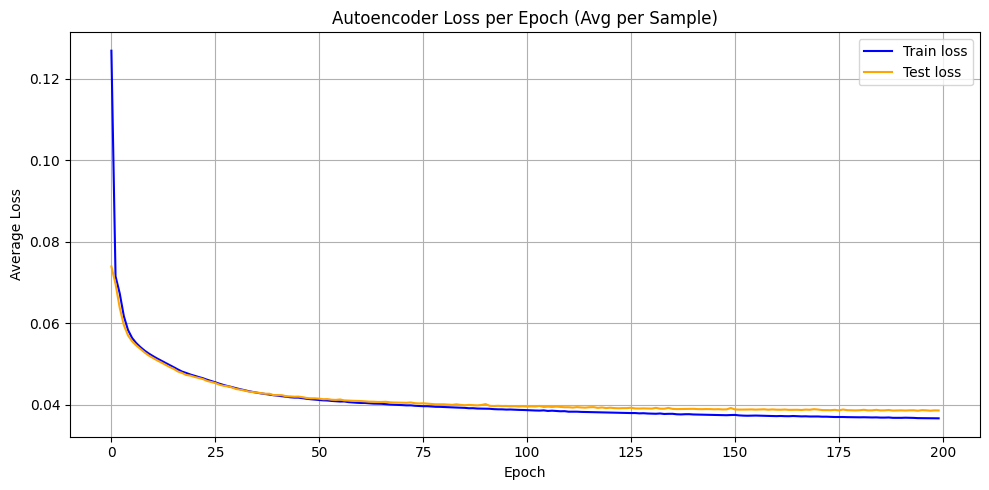

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train loss", color='blue')
plt.plot(test_loss_history, label="Test loss", color='orange')
plt.title("Autoencoder Loss per Epoch (Avg per Sample)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



# Visual Testing
----------------------

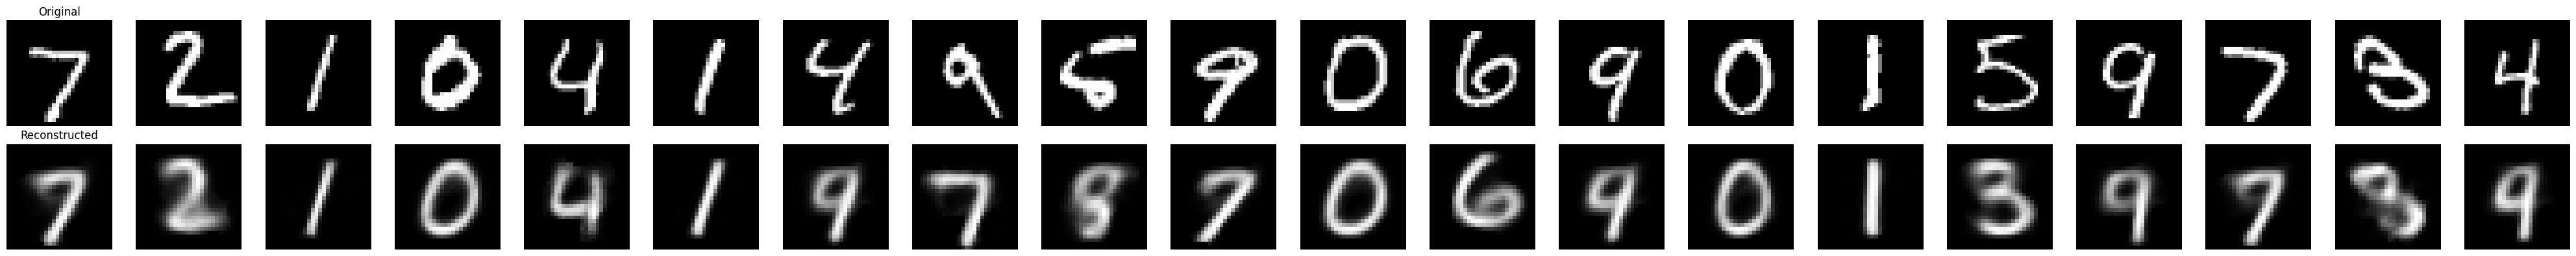

In [ ]:
import numpy as np

# Number of examples to show
N = 20

net.eval()
fig, axs = plt.subplots(2, N, figsize=(2 * N, 4))

test_iter = iter(testloader_1)
for i in range(N):
    img, _ = next(test_iter)
    img = img.to(device)

    with torch.no_grad():
        recon = net(img)

    axs[0, i].imshow(img[0, 0].cpu().numpy(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(recon[0, 0].cpu().numpy(), cmap="gray")
    axs[1, i].axis("off")

axs[0, 0].set_title("Original")
axs[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()

# Latent Space
----------------------

It is instructive to plot the bottleneck (for the test set) in a 2D plot. As a comparison, we will plot the PCA of the test set to the side.

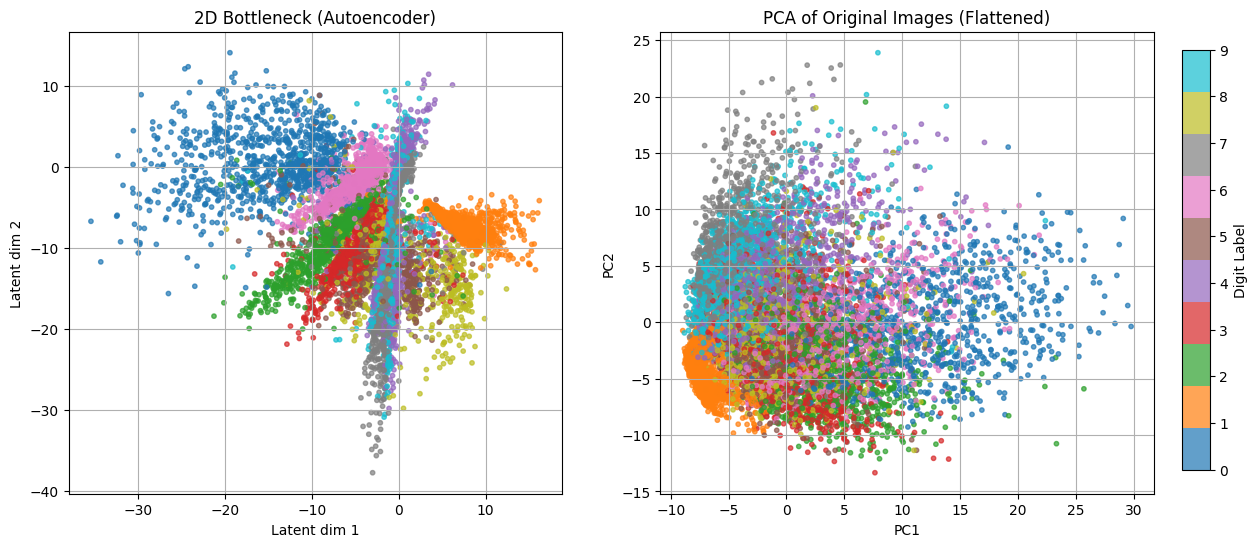

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# === Collect latent codes and raw data ===
net.eval()
all_latents = []
all_labels = []
raw_images = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        latents = net.encoder(inputs)

        all_latents.append(latents.cpu())
        all_labels.append(labels)
        raw_images.append(inputs.cpu().view(inputs.size(0), -1))  # Flatten: (B, 784)

all_latents = torch.cat(all_latents).numpy()
all_labels = torch.cat(all_labels).numpy()
raw_images = torch.cat(raw_images).numpy()

# === PCA ===
scaler = StandardScaler()
raw_images_std = scaler.fit_transform(raw_images)
pca = PCA(n_components=2)
raw_images_2d = pca.fit_transform(raw_images_std)

# === Plot side-by-side with proper colorbar ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bottleneck
sc1 = axes[0].scatter(all_latents[:, 0], all_latents[:, 1], c=all_labels, cmap="tab10", s=10, alpha=0.7)
axes[0].set_title("2D Bottleneck (Autoencoder)")
axes[0].set_xlabel("Latent dim 1")
axes[0].set_ylabel("Latent dim 2")
axes[0].grid(True)

# PCA
sc2 = axes[1].scatter(raw_images_2d[:, 0], raw_images_2d[:, 1], c=all_labels, cmap="tab10", s=10, alpha=0.7)
axes[1].set_title("PCA of Original Images (Flattened)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].grid(True)

# Shared colorbar – place to the right of both subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sc2, cax=cbar_ax, ticks=range(10), label='Digit Label')

plt.subplots_adjust(right=0.9)  # make room for colorbar
plt.show()


# 16 Dimensional Bottleneck Network

To experience a little bit more expressive network, let us now train another network, with a 16D bottleneck.

## Task

How could we attempt plotting the 16D bottleneck of this network?

In [ ]:
#### TRAINING THE 16D BOTTLENECK

import time
import torch
import torch.nn.functional as F

# Start timing
start_time = time.time()

BOTTLENECK = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net_16 = Autoencoder(bottleneck_dimensionality=BOTTLENECK).to(device)
optimizer = torch.optim.Adam(net_16.parameters(), lr=0.001)

EPOCHS = 200
train_loss_history = []
test_loss_history = []

for epoch in range(EPOCHS):
    # === Train ===
    net_16.train()
    epoch_loss_sum = 0.0
    epoch_sample_count = 0

    for batch_inputs, _ in trainloader:
        batch_inputs = batch_inputs.to(device)

        optimizer.zero_grad()
        reconstructed = net_16(batch_inputs)

        loss = F.mse_loss(reconstructed, batch_inputs, reduction='mean')
        loss.backward()
        optimizer.step()

        batch_size = batch_inputs.size(0)
        epoch_loss_sum += loss.item() * batch_size
        epoch_sample_count += batch_size

    avg_train_loss = epoch_loss_sum / epoch_sample_count
    train_loss_history.append(avg_train_loss)

    # === Evaluate on test set ===
    net_16.eval()
    test_loss_sum = 0.0
    test_sample_count = 0
    with torch.no_grad():
        for batch_inputs, _ in testloader:
            batch_inputs = batch_inputs.to(device)
            reconstructed = net_16(batch_inputs)
            loss = F.mse_loss(reconstructed, batch_inputs, reduction='mean')

            batch_size = batch_inputs.size(0)
            test_loss_sum += loss.item() * batch_size
            test_sample_count += batch_size

    avg_test_loss = test_loss_sum / test_sample_count
    test_loss_history.append(avg_test_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss (averaged over the epoch): {avg_train_loss:.6f} | Test Loss (after the epoch): {avg_test_loss:.6f}")

# End timing
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.2f} seconds")



Working on cuda
Epoch 000 | Train Loss (averaged over the epoch): 0.126564 | Test Loss (after the epoch): 0.074651
Epoch 010 | Train Loss (averaged over the epoch): 0.034184 | Test Loss (after the epoch): 0.033032
Epoch 020 | Train Loss (averaged over the epoch): 0.024958 | Test Loss (after the epoch): 0.024276
Epoch 030 | Train Loss (averaged over the epoch): 0.020950 | Test Loss (after the epoch): 0.020471
Epoch 040 | Train Loss (averaged over the epoch): 0.018558 | Test Loss (after the epoch): 0.018166
Epoch 050 | Train Loss (averaged over the epoch): 0.017089 | Test Loss (after the epoch): 0.016827
Epoch 060 | Train Loss (averaged over the epoch): 0.015858 | Test Loss (after the epoch): 0.015610
Epoch 070 | Train Loss (averaged over the epoch): 0.014867 | Test Loss (after the epoch): 0.014636
Epoch 080 | Train Loss (averaged over the epoch): 0.014045 | Test Loss (after the epoch): 0.013868
Epoch 090 | Train Loss (averaged over the epoch): 0.013384 | Test Loss (after the epoch): 0.0

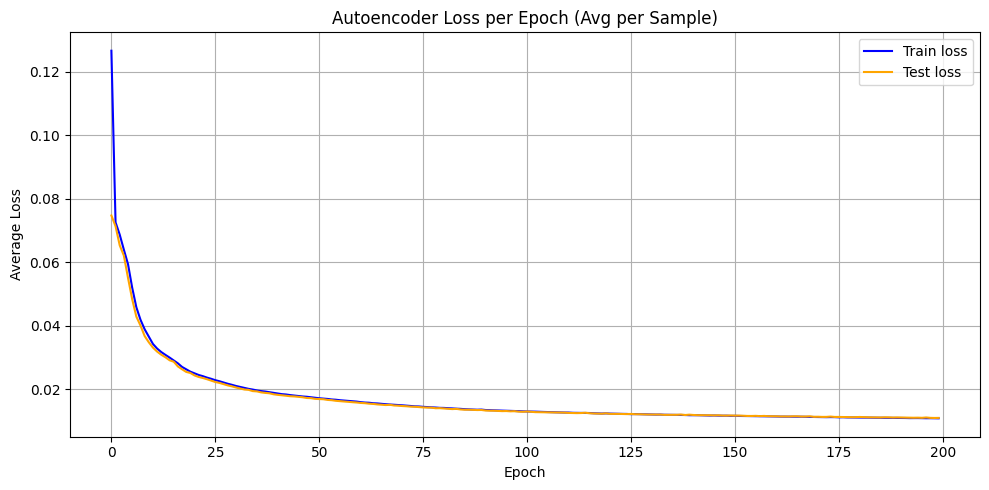

In [ ]:
#### VISUALISING LEARNING PROGRESS

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Train loss", color='blue')
plt.plot(test_loss_history, label="Test loss", color='orange')
plt.title("Autoencoder Loss per Epoch (Avg per Sample)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



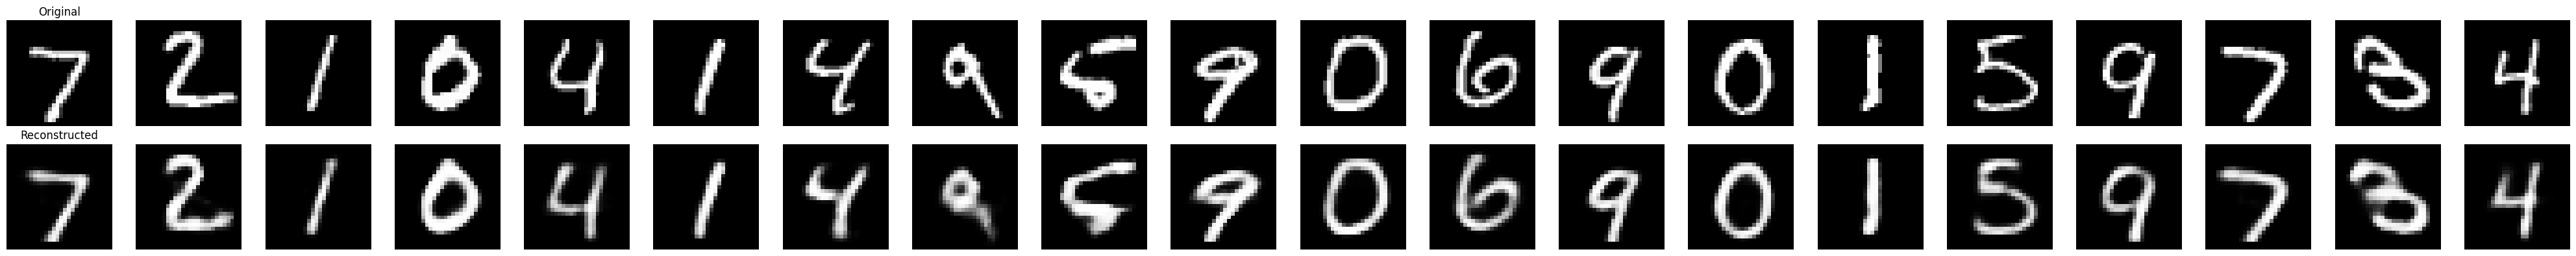

In [ ]:
#### SOME EXAMPLES

N = 20 # Number of examples to show

net_16.eval()
fig, axs = plt.subplots(2, N, figsize=(2 * N, 4))

test_iter = iter(testloader_1)
for i in range(N):
    img, _ = next(test_iter)
    img = img.to(device)

    with torch.no_grad():
        recon = net_16(img)

    axs[0, i].imshow(img[0, 0].cpu().numpy(), cmap="gray")
    axs[0, i].axis("off")
    axs[1, i].imshow(recon[0, 0].cpu().numpy(), cmap="gray")
    axs[1, i].axis("off")

axs[0, 0].set_title("Original")
axs[1, 0].set_title("Reconstructed")
plt.tight_layout()
plt.show()



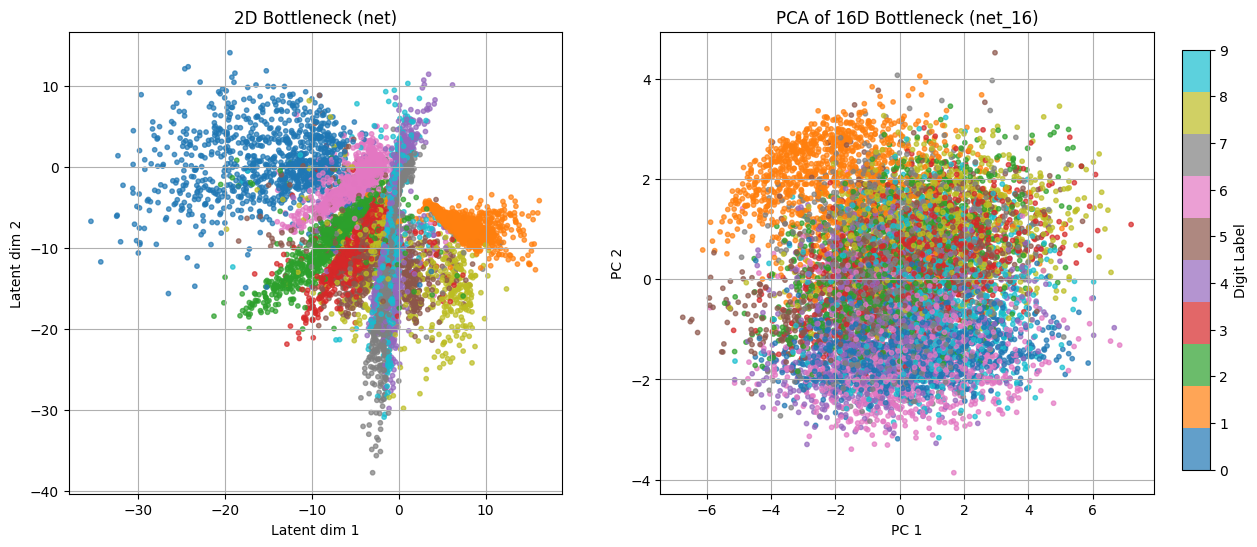

In [ ]:
#### AND FINALY THE 16D BOTTLENECK PLOTTED (ONLY ITS 2 PRINCIPAL COMPONENTS GET PLOTTED)

net.eval()
net_16.eval()

def get_latents(net, dataloader):
    all_latents, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            latents = net.encoder(inputs)
            all_latents.append(latents.cpu())
            all_labels.append(labels)
    return torch.cat(all_latents).numpy(), torch.cat(all_labels).numpy()

# Get latent spaces
latents_2d, labels = get_latents(net, testloader)
latents_16d, _ = get_latents(net_16, testloader)

# PCA: 16D to 2D
latents_16d_pca = PCA(n_components=2).fit_transform(StandardScaler().fit_transform(latents_16d))

# === Plot side-by-side with proper colorbar ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: true 2D bottleneck
sc1 = axes[0].scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7)
axes[0].set_title("2D Bottleneck (net)")
axes[0].set_xlabel("Latent dim 1")
axes[0].set_ylabel("Latent dim 2")
axes[0].grid(True)

# Right: PCA of 16D bottleneck
sc2 = axes[1].scatter(latents_16d_pca[:, 0], latents_16d_pca[:, 1], c=labels, cmap="tab10", s=10, alpha=0.7)
axes[1].set_title("PCA of 16D Bottleneck (net_16)")
axes[1].set_xlabel("PC 1")
axes[1].set_ylabel("PC 2")
axes[1].grid(True)

# Shared colorbar – placed explicitly to the right
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(sc2, cax=cbar_ax, ticks=range(10), label='Digit Label')

plt.subplots_adjust(right=0.9)  # make room for colorbar
plt.show()

## Saving local state to load it after closing this page

In [ ]:
from google.colab import files

torch.save(net.state_dict(), 'net_state_dict.pth')
torch.save(net_16.state_dict(), 'net_16_state_dict.pth')

files.download('net_state_dict.pth')
files.download('net_16_state_dict.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
from google.colab import files
uploaded = files.upload()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = Autoencoder(bottleneck_dimensionality=2).to(device)
net_16 = Autoencoder(bottleneck_dimensionality=16).to(device)

net.load_state_dict(torch.load('net_state_dict.pth'))
net_16.load_state_dict(torch.load('net_16_state_dict.pth'))

net.eval()
net_16.eval()

Saving net_16_state_dict.pth to net_16_state_dict.pth
Saving net_state_dict.pth to net_state_dict.pth
Working on cuda


Autoencoder(
  (encoder): EncoderMLP(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=784, out_features=256, bias=True)
    (linear2): Linear(in_features=256, out_features=64, bias=True)
    (linear3): Linear(in_features=64, out_features=16, bias=True)
  )
  (decoder): DecoderMLP(
    (relu): ReLU()
    (linear1): Linear(in_features=16, out_features=64, bias=True)
    (linear2): Linear(in_features=64, out_features=256, bias=True)
    (linear3): Linear(in_features=256, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Denoising
----------------------

**Denoising** refers to the process of removing noise from corrupted images.

In many real-world scenarios, capturing a clean image is difficult or even impossible due to suboptimal conditions during image acquisition or transmission, which leads to the introduction of noise.

An example of such conditions is taking a photo at night, motion blur, poor-quality sensors, or image degradation during transmission over unstable communication channels.

An autoencoder trained on clean images learns a compact internal representation (in the bottleneck) that captures the essential structure of valid data — in our case, digits. This compressed representation acts as a kind of "filter", discarding the irrelevant details and retaining what makes the digit recognizable.

So when you pass a noisy image through the encoder, the network will try to map it to the closest valid bottleneck it knows — that is, one that likely came from a clean digit. Then, when you decode from that bottleneck, the decoder outputs an image that matches what it thinks that bottleneck represents — effectively removing the noise in the process.

This works well as long as the noise doesn’t distort the image beyond what the encoder can still recognize as a digit.

Working on cuda


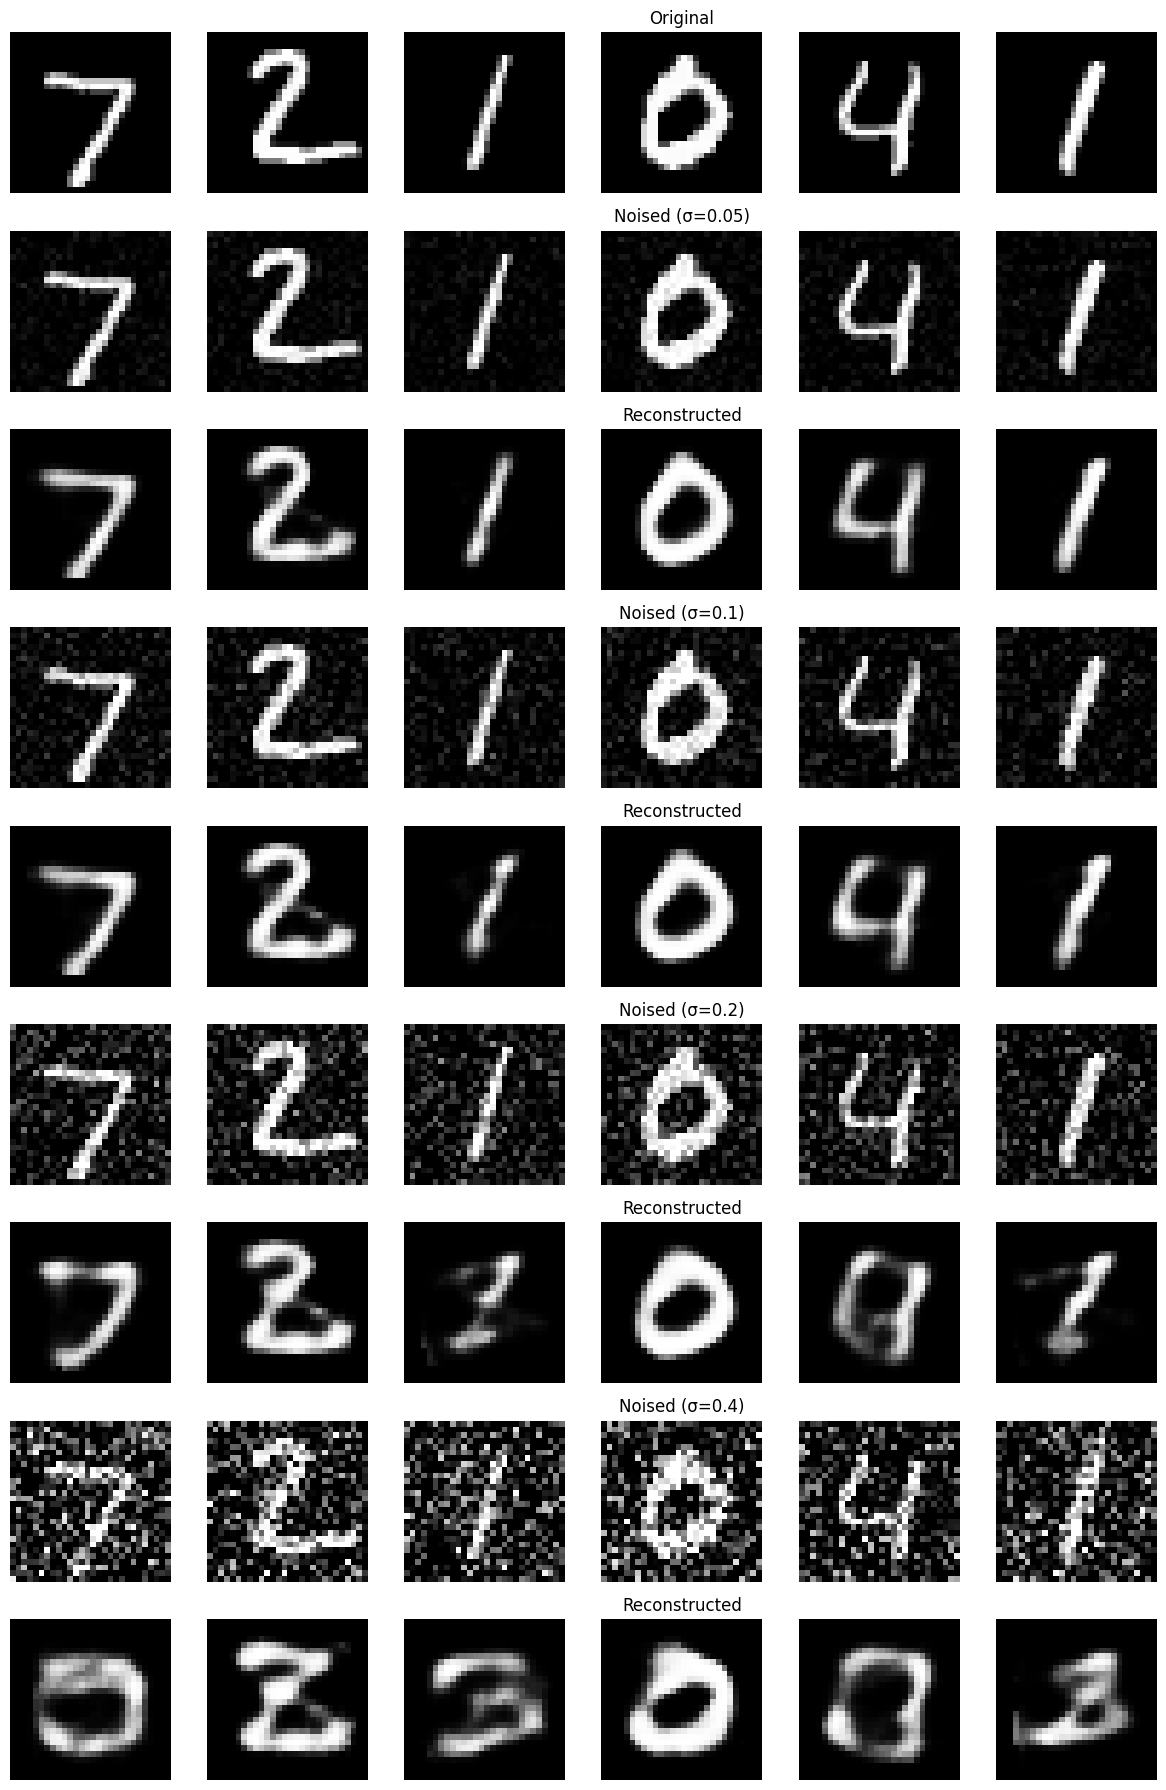

In [ ]:
import numpy
import matplotlib.pyplot as plt
import torch
from torch.functional import F
from torch import nn


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

# Ensure evaluation mode
net_16.eval()

# Configuration
noise_levels = [0.05, 0.1, 0.2, 0.4]
N = 6  # Number of samples

# Collect N samples from testloader (assuming batch_size=1)
samples = []
for i, (img, _) in enumerate(testloader_1):
    samples.append(img)
    if len(samples) >= N:
        break
images = torch.cat(samples, dim=0).to(device)  # shape: (N, 1, 28, 28)

def add_noise(imgs, level):
    noise = torch.randn_like(imgs) * level
    return torch.clamp(imgs + noise, 0., 1.)

# We have:
#   row 0 -> original images
#   for each noise level -> 2 rows:
#       row (noisy)
#       row (reconstructed)

num_rows = 1 + 2 * len(noise_levels)
fig, axes = plt.subplots(num_rows, N, figsize=(N * 2, num_rows * 2))

# --- Row 0: Original images ---
for j in range(N):
    axes[0, j].imshow(images[j, 0].cpu().numpy(), cmap="gray")
    axes[0, j].axis("off")

# Give a title in the center of row 0
if N > 0:
    axes[0, N // 2].set_title("Original", fontsize=12)

# --- Rows per noise level ---
for i, level in enumerate(noise_levels):
    # Create noisy + denoised
    noisy = add_noise(images, level)
    with torch.no_grad():
        denoised = net_16(noisy)

    # Identify which rows in the subplot grid
    noisy_row = 1 + 2 * i
    denoised_row = noisy_row + 1

    # Plot all N samples in each row
    for j in range(N):
        # Noisy
        axes[noisy_row, j].imshow(noisy[j, 0].cpu().numpy(), cmap="gray")
        axes[noisy_row, j].axis("off")

        # Denoised
        axes[denoised_row, j].imshow(denoised[j, 0].cpu().numpy(), cmap="gray")
        axes[denoised_row, j].axis("off")

    # Titles for each row (centered)
    axes[noisy_row, N // 2].set_title(f"Noised (σ={level})", fontsize=12)
    axes[denoised_row, N // 2].set_title("Reconstructed", fontsize=12)

plt.tight_layout()
plt.show()


# Anomaly Detecion
---------------

**Anomaly detection** refers to identifying data samples that deviate significantly from what is considered normal or expected.

In image-based tasks, anomalies can be images that do not resemble the training data, such as digits drawn in an unusual style, incorrect symbols, or even entirely different types of images.

An autoencoder trained solely on clean and valid digits learns to reconstruct inputs that resemble the training distribution. It captures the core structure of these digits in its bottleneck representation and learns to map inputs through this structure.

When such a model is presented with an anomalous image — one that differs significantly from the digits it has seen — it struggles to reconstruct it accurately. The bottleneck fails to capture meaningful structure, and the decoder produces a poor approximation of the input.

This discrepancy between the original input and the reconstructed output — usually measured by the reconstruction error — serves as a signal: if the error is high, the input is likely anomalous. In this way, the autoencoder becomes a powerful tool for detecting unexpected or out-of-distribution inputs.

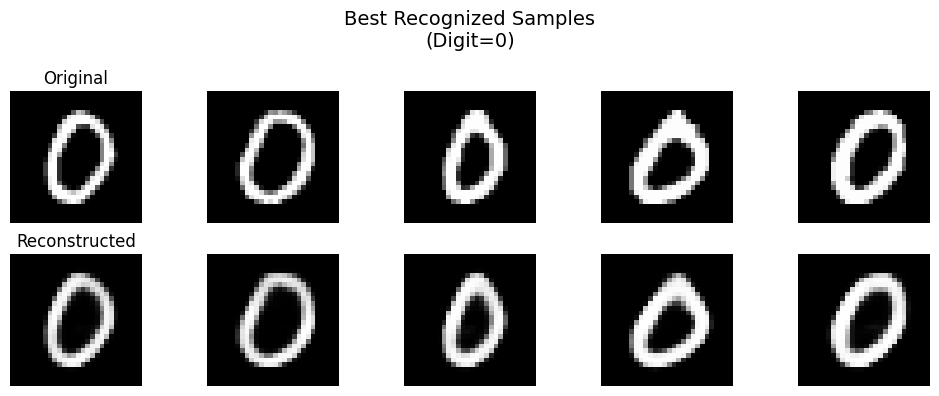

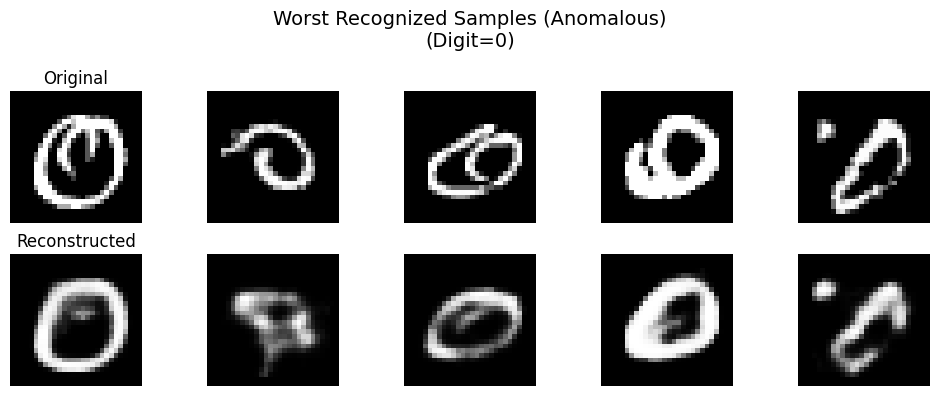

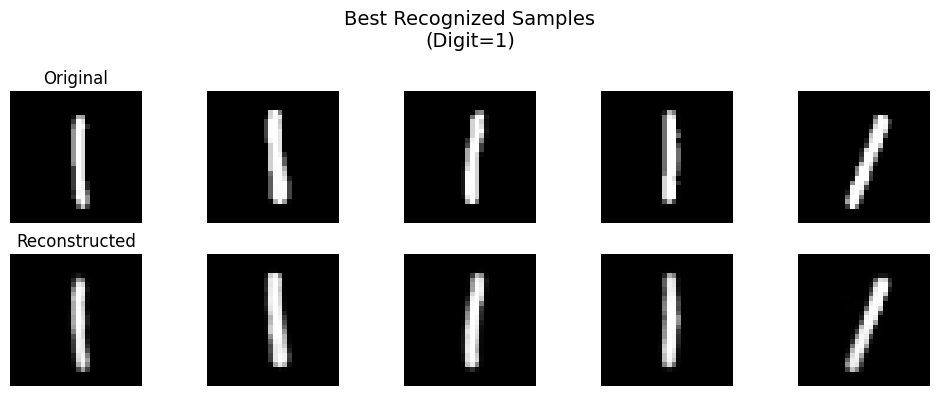

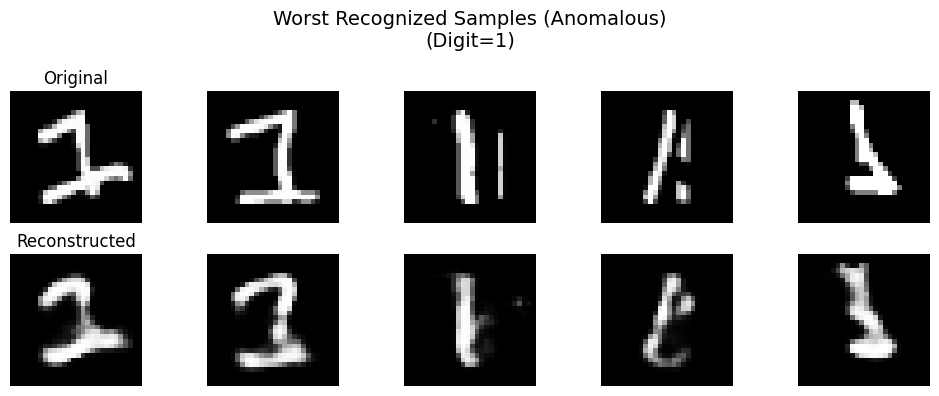

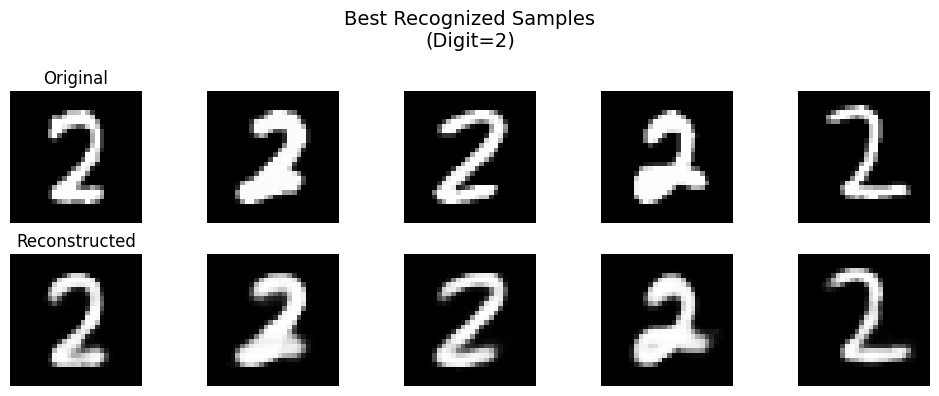

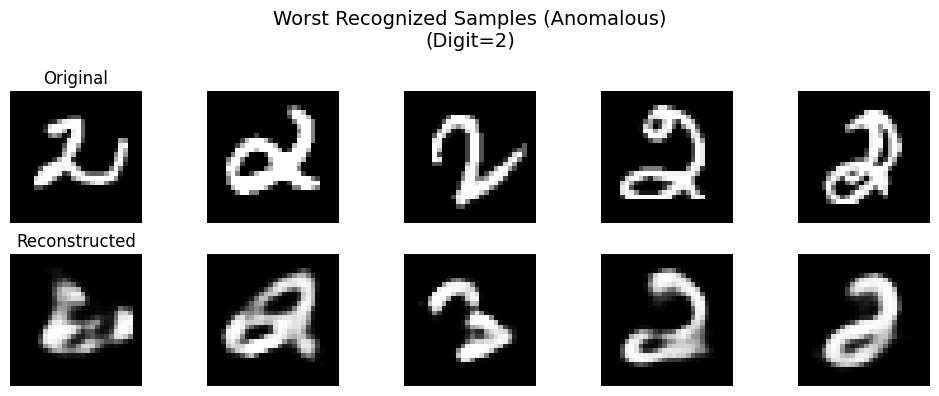

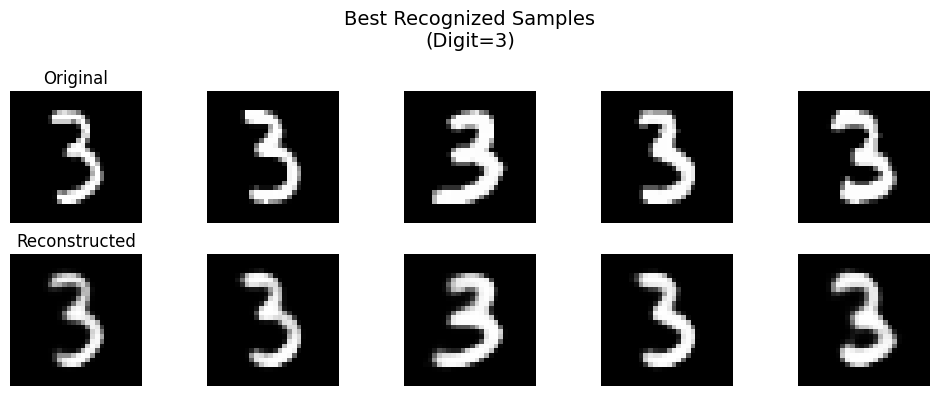

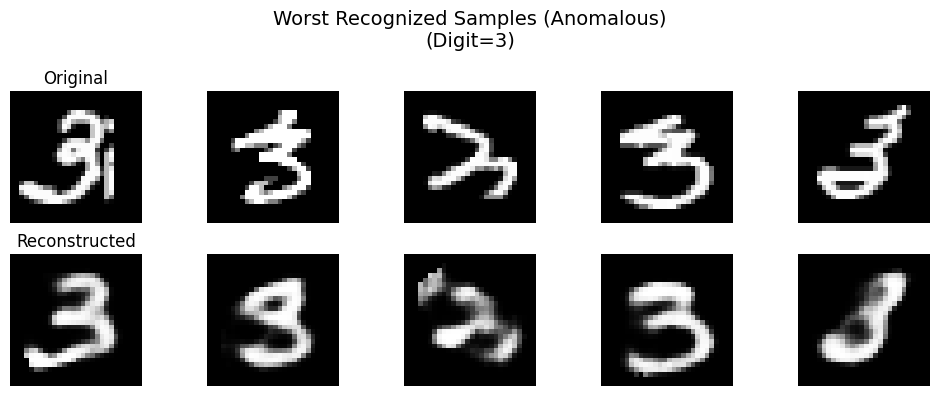

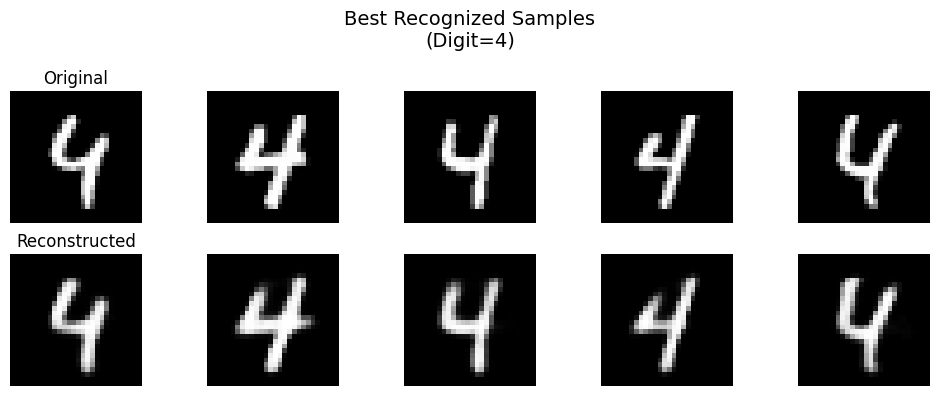

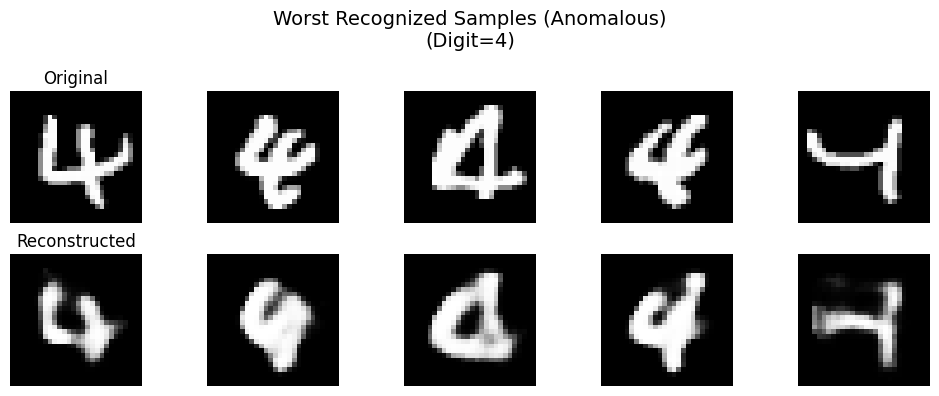

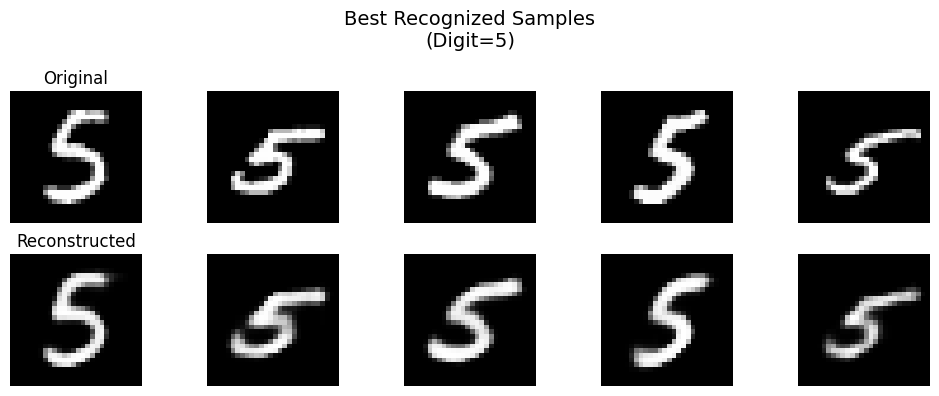

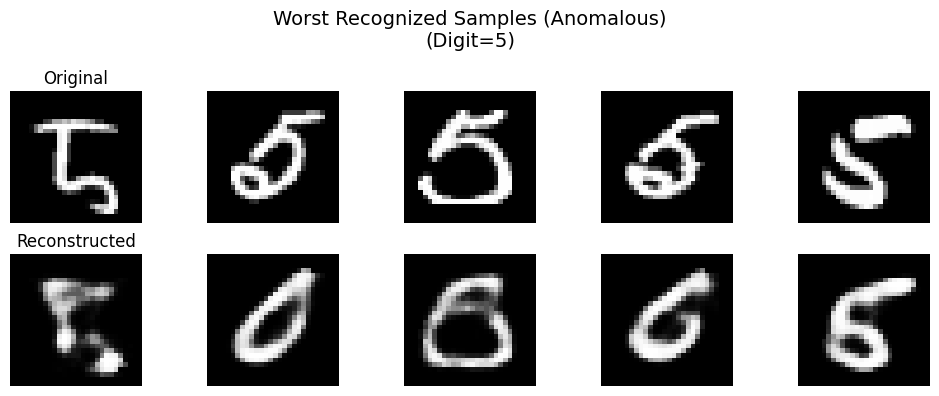

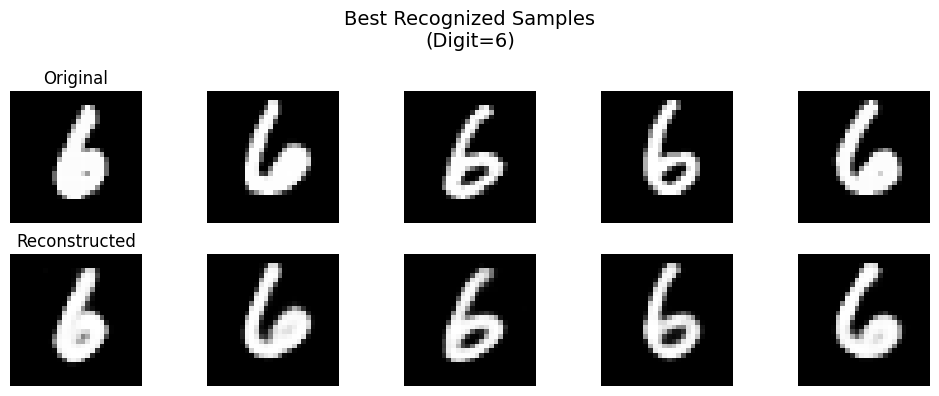

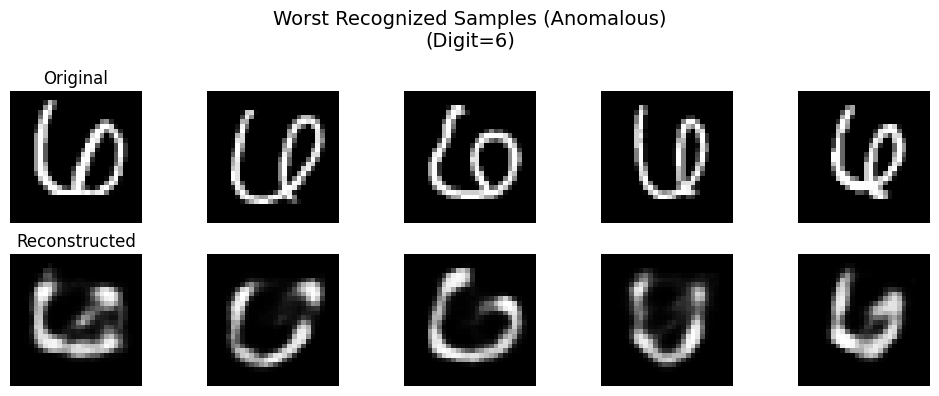

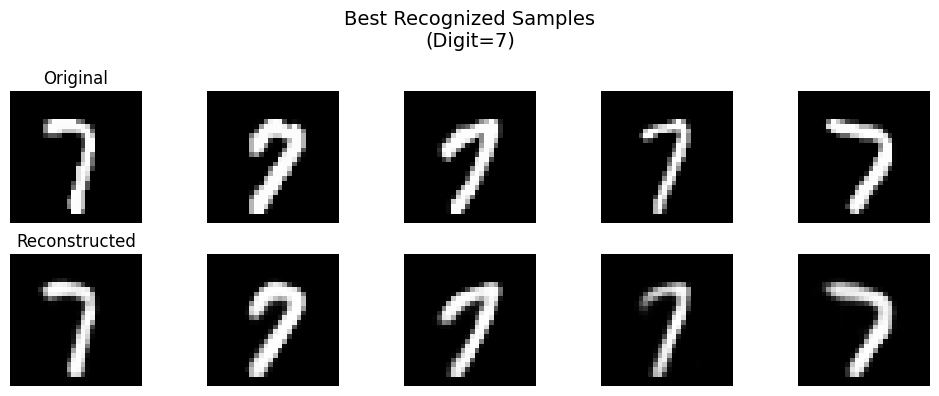

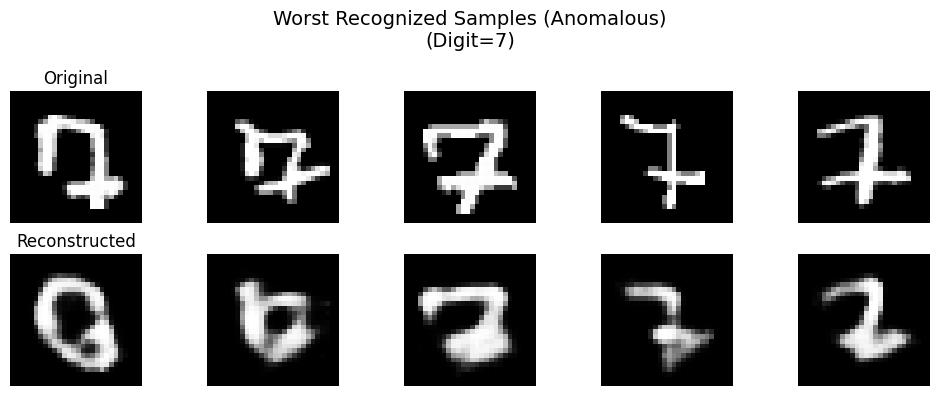

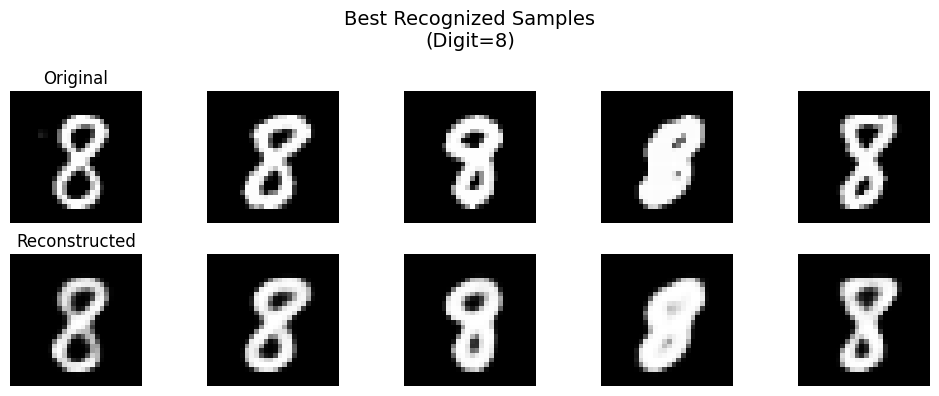

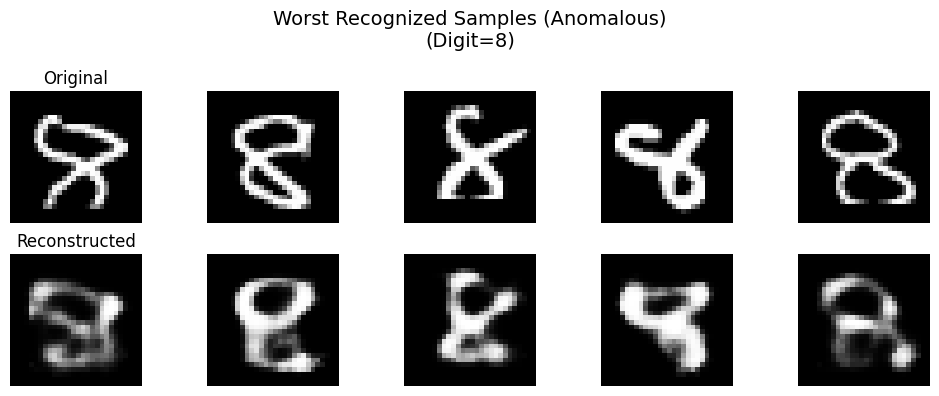

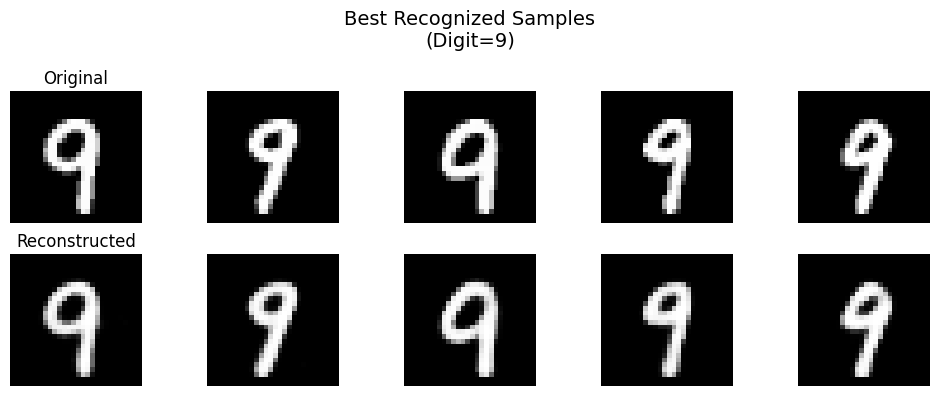

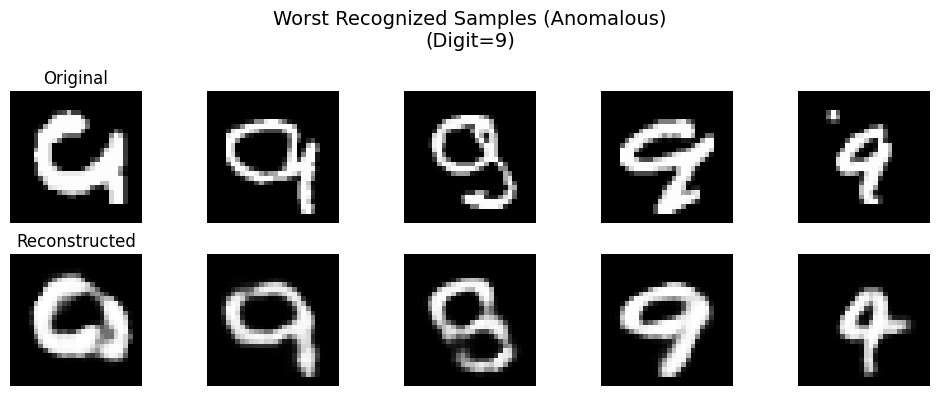

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

net_16.eval()
N = 5  # How many images (best/worst) to present per label

for current_label in range(10):
    reconstruction_errors = []
    originals = []
    reconstructions = []

    with torch.no_grad():
        for batch_inputs, batch_labels in testloader:
            # Filter out samples belonging to the current label
            mask = (batch_labels == current_label)
            if mask.sum() == 0:
                continue

            # Keep only the relevant images
            relevant_images = batch_inputs[mask].to(device)
            # Forward pass
            recon = net_16(relevant_images)

            # Compute MSE per sample
            errors = F.mse_loss(recon, relevant_images, reduction='none')
            errors = errors.view(errors.size(0), -1).mean(dim=1)  # average MSE per image

            reconstruction_errors.extend(errors.cpu().numpy())
            originals.extend(relevant_images.cpu())
            reconstructions.extend(recon.cpu())

    # If no images with this label exist in testloader, skip
    if len(reconstruction_errors) == 0:
        print(f"No samples found for label {current_label}")
        continue

    # Convert to tensors for easier indexing
    reconstruction_errors = torch.tensor(reconstruction_errors)
    originals = torch.stack(originals)
    reconstructions = torch.stack(reconstructions)

    # Find indices of best and worst reconstructions
    best_indices = torch.topk(-reconstruction_errors, N).indices  # negative for smallest
    worst_indices = torch.topk(reconstruction_errors, N).indices

    def show_comparisons(indices, title):
        num_show = len(indices)
        fig, axs = plt.subplots(2, num_show, figsize=(2 * num_show, 4))
        for i, idx in enumerate(indices):
            axs[0, i].imshow(originals[idx][0], cmap='gray')
            axs[0, i].axis('off')
            axs[1, i].imshow(reconstructions[idx][0], cmap='gray')
            axs[1, i].axis('off')
        axs[0, 0].set_title("Original")
        axs[1, 0].set_title("Reconstructed")
        fig.suptitle(f"{title}\n(Digit={current_label})", fontsize=14)
        plt.tight_layout()
        plt.show()

    # Show best reconstructions
    show_comparisons(best_indices, "Best Recognized Samples")

    # Show worst reconstructions
    show_comparisons(worst_indices, "Worst Recognized Samples (Anomalous)")


# **Homework Assignment: Understanding Deconvolution in Autoencoders**
---------------

In class, we worked with autoencoders built from multilayer perceptrons (MLPs). However, encoders are often constructed using convolutional architectures to better capture spatial patterns. In this assignment, you'll explore how the decoder can use deconvolutional (transposed convolution) layers to reverse and mirror the operations performed by the convolutional encoder.

While convolutional encoders are relatively well understood, **decoding (or upsampling) the compressed representation** using **deconvolutional layers** (also known as **transposed convolutions**) often raises questions.

This assignment is particularly relevant because deconvolution is a core component of the U-Net architecture, a prominent neural network used extensively in image segmentation tasks.

Your main objective is to deeply understand **how transposed convolution layers work**, and explain them in both words and visuals.


## **The Objective**

Understand and clearly explain how **transposed convolutions** work. Use 2D transposed convolutions and a small grid of 2D points as a working example.

You may need to do some additional reading to complete this assignment.

## **Tasks & Deliverables**

### 1. **Theory Exploration**

Using markdown cells in your Colab notebook, answer the following:

- What is a **transposed convolution**?
- How does it differ from a regular convolution?
- How does it upsample feature maps?
- What are **stride**, **padding**, and **kernel size**, and how do they influence the result in a transposed convolution?
- To earn full two points, your explanation must be detailed enough for a reader to reproduce the upsampling process step by step.


### 2. **Manual Diagram (by your hand, not a generated image)**

Carefully plan and draw **by hand** a diagram or a set of diagrams that:

- Explain the process of using **transposed convolution**.
- Use an example of a **small input grid of 2D points** which gets expanded into a larger output grid.
- Explain how stride, padding, and the kernel shape affect the result.
- Show intermediate steps of the operation, not just input and output.

**Scan or photograph your diagram(s)**, and upload it to your **GitHub repository** for this course.

Then embed it in your Colab notebook using markdown (you can find examples on *how to do it* in previous notebooks related to this class, e.g. the one on linear regression or the one on the MLP network).


### 3. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


##**Answers:**
1a, 1b) Transposed Convolution is a process of unsqueezing the images (or other patterns). While convolution reduces shape of input data, deconvolution (or transposed convolution) extends it and tries to learn how to recreate on original pattern.

----------------
1c) It uses (as well as convolution layer) kernels, strides and padding and as well goes around an input data, stride by stride, peace by peace and learns the weights how it can recreate an image/pattern. After each leayer output image is usually bigger than input image.

--------------
1d)
#Strides:
1. Greater the stride — the more complex features can be found in the data.

2. The more striding will be applied, the more low-level features will be ignored and we'll catch only high-level features — and sometimes we only need so few.

3. In transposed convolutions, a larger stride increases the upsampling factor — i.e., the output becomes larger, "stretching" the image.

#Padding:
1. Filter goes beyond the input image — so we need to pad the input to maintain dimensions.

2. Padding controls output size and helps to preserve spatial information near the edges - this is important since original images was squeazed and important features can be hidden on the borders.

3. In transposed convolutions, padding can affect where the zeros are inserted, and thus change the output dimensions and feature alignment.

#Kernel shape:
1. Determines the receptive field of the operation — i.e., how many input values are used to compute a single output value.

2. Larger kernels capture broader context, but may blur fine details.

3. In transposed convolution, kernel size influences how the inserted zeros and weights combine to reconstruct higher-resolution outputs.

--------------------
1e)